### descriptive statistics for Vision Zero Code ###
by Richard Sowers and Lucas Gong

* <r-sowers@illinois.edu>
* <shuog2@illinois.edu>

<https://publish.illinois.edu/r-sowers/>

Copyright 2018 University of Illinois Board of Trustees. All Rights Reserved. Licensed under the MIT license

imports

In [1]:
from matplotlib import pylab as plotter
%matplotlib inline
import osmnx
import networkx
import pandas
import numpy
import datetime
import importlib
import MAIN_config_hour_of_day as config
#import MAIN_config_seasons as config

External files

In [2]:
windower=config.windower()

Manhattan whole day


construct street network; G_raw is archival version

In [3]:
osmnx.config(log_file=True, log_console=True, use_cache=True)

In [4]:
G_raw = osmnx.graph_from_place('Manhattan Island, New York, USA', network_type='drive')

copy from reference graph to usable graph

In [5]:
G=networkx.DiGraph(G_raw)

In [6]:
N_nodes=len(G.nodes)
N_edges=len(G.edges)
print("there are "+str(N_nodes)+" nodes and "+str(N_edges)+" edges in Manhattan")

there are 4468 nodes and 9683 edges in Manhattan


In [7]:
def weekday(dt):
    return dt.isoweekday()<=5
    
def in_manhattan(node):
    return node in G.nodes

## traveltime data ##

In [8]:
traveltimes_raw=config.traveltimes()

In [9]:
traveltimes=pandas.DataFrame(traveltimes_raw)
print(traveltimes.head())

         begin_node    end_node            datetime  travel_time  num_trips
1403701    42434279    42443674 2012-12-26 23:00:00     14.36930        135
1403702    42434237    42444835 2012-12-26 23:00:00     10.57470          3
1403703  1372888616    42522888 2012-12-26 23:00:00      9.71205          3
1403704    42434196  1773121034 2012-12-26 23:00:00     15.76400         50
1403705   598622198   598622326 2012-12-26 23:00:00     14.67750          1


In [10]:
t_min=min(traveltimes["datetime"])
t_max=max(traveltimes["datetime"])
print("datetime range of traveltime data is ["+
      str(t_min)+","+str(t_max)+"]")
print(str(len(traveltimes))+" records total")

datetime range of traveltime data is [2012-01-06 00:00:00,2012-12-26 23:00:00]
14243122 records total


In [11]:
# reduce traveltimes, but gradually
flags=traveltimes["datetime"].apply(weekday)
traveltimes=traveltimes[flags]
flags=traveltimes["begin_node"].apply(in_manhattan)
traveltimes=traveltimes[flags]
flags=traveltimes["end_node"].apply(in_manhattan)
traveltimes=traveltimes[flags]
print("there are "+str(len(traveltimes))+" weekday records in Manhattan")

there are 6108725 weekday records in Manhattan


In [12]:
datetimerange=pandas.date_range(start=t_min, end=t_max, 
                                freq=datetime.timedelta(hours=1))
datetimerange=datetimerange.map(weekday)
print("there are "+str(len(datetimerange))+" weekday hours in ["+str(t_min)+
      ","+str(t_max)+"]")

there are 8544 weekday hours in [2012-01-06 00:00:00,2012-12-26 23:00:00]


In [13]:
traveltimes["hour"]=traveltimes["datetime"].apply(lambda dt: dt.hour)

def getspeed(row):
    #print(row,flush=True)
    try:
        speed=G.edges[row["begin_node"],row["end_node"]]["length"]/row["travel_time"]
        return speed
    except Exception:
        return numpy.nan
    
traveltimes["speed"]=traveltimes.apply(getspeed,axis=1)
traveltimes.head()

,begin_node,end_node,datetime,travel_time,num_trips,hour,speed
1403701,42434279,42443674,2012-12-26 23:00:00,14.36930,135,23,5.545155
1403702,42434237,42444835,2012-12-26 23:00:00,10.57470,3,23,6.941568
1403704,42434196,1773121034,2012-12-26 23:00:00,15.76400,50,23,NaN
1403706,42434233,42444833,2012-12-26 23:00:00,24.16290,17,23,3.039329
1403707,42434226,42444832,2012-12-26 23:00:00,8.02966,2,23,9.180214


In [14]:
traveltimes.set_index(["begin_node","end_node","hour"],drop=True,inplace=True)
traveltimes.head()

,,,datetime,travel_time,num_trips,speed
begin_node,end_node,hour,,,,
42434279,42443674,23,2012-12-26 23:00:00,14.36930,135,5.545155
42434237,42444835,23,2012-12-26 23:00:00,10.57470,3,6.941568
42434196,1773121034,23,2012-12-26 23:00:00,15.76400,50,NaN
42434233,42444833,23,2012-12-26 23:00:00,24.16290,17,3.039329
42434226,42444832,23,2012-12-26 23:00:00,8.02966,2,9.180214


In [15]:
temp=traveltimes.groupby(level=["begin_node","end_node","hour"])
print("there are "+str(len(temp))+" OD-hour records")

there are 172067 OD-hour records


hour
0    259948
1    240372
2    220762
3    204083
4    200847
dtype: int64


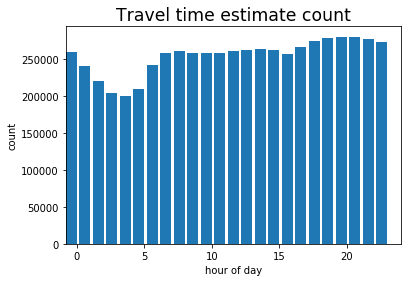

In [37]:
temp=traveltimes.groupby(level="hour").size()
print(temp.head())
plotter.figure()
#Diff.hist(range)
width=0.8
plotter.bar(temp.index-width/2,
            numpy.array(temp),width=width)
title="Travel time estimate count"
plotter.xlim((-width,24))
plotter.title(title,fontsize='xx-large')
plotter.xlabel("hour of day",fontsize='medium')
plotter.ylabel("count",fontsize='medium')
plotter.savefig("images/traveltime_count.png",bbox_inches='tight')
plotter.show()
plotter.close()


hour
0    7.765044
1    8.145218
2    8.555981
3    8.705359
4    9.250491
Name: speed, dtype: float64


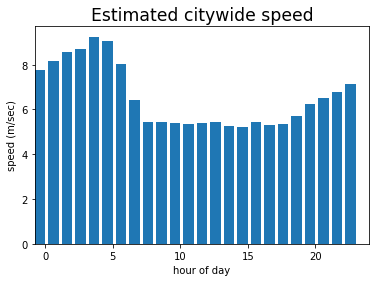

In [38]:
temp=traveltimes["speed"].groupby(level="hour").mean()
print(temp.head())
plotter.figure()
width=0.8
plotter.bar(temp.index-width/2,
            numpy.array(temp),
           width=width)
title="Estimated citywide speed"
plotter.title(title,fontsize='xx-large')
plotter.xlim((-width,24))
plotter.xlabel("hour of day",fontsize='medium')
plotter.ylabel("speed (m/sec)",fontsize='medium')
plotter.savefig("images/estimated_speed.png",bbox_inches='tight')
plotter.show()
plotter.close()


## accident data ##

In [18]:
accidents_raw=config.accidents()

In [19]:
accidents=pandas.DataFrame(accidents_raw)
print(accidents.head())

       node            datetime
0  42433712 2015-09-16 07:40:00
1  42433715 2015-10-07 17:50:00
2  42433715 2015-10-30 17:13:00
3  42427412 2015-01-18 12:00:00
4  42427412 2015-08-06 08:00:00


In [20]:
t_min=min(accidents["datetime"])
t_max=max(accidents["datetime"])
print("datetime range of accident data is ["+
      str(t_min)+","+str(t_max)+"]")
print(str(len(accidents))+" accidents ")
accident_frequency=len(accidents)/((t_max-t_min)/datetime.timedelta(hours=1))
print(str(accident_frequency)+" accidents/hour on average")

datetime range of accident data is [2014-01-01 00:01:00,2017-12-31 23:40:00]
144263 accidents 
4.114317819166002 accidents/hour on average


In [21]:
# reduce accidents, but gradually
flags=accidents["datetime"].map(weekday)
accidents=accidents[flags]
flags=accidents["node"].map(in_manhattan)
accidents=accidents[flags]
print("there are "+str(len(accidents))+" weekday accidents in Manhattan")

there are 108659 weekday accidents in Manhattan


In [22]:
temp=pandas.unique(accidents["node"])
print(str(len(temp))+" unique accident locations")

3733 unique accident locations


In [23]:
accidents["hour"]=accidents["datetime"].map(lambda dt: dt.hour)
accidents.set_index("hour",drop=True,inplace=True)

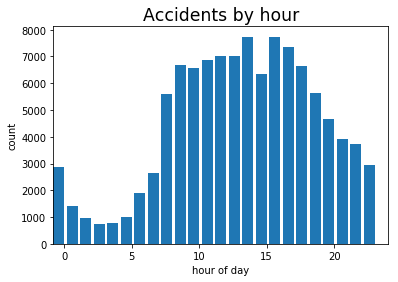

In [39]:
temp=accidents.groupby(level="hour").size()
temp.head()
plotter.figure()
width=0.8
plotter.bar(temp.index-width/2,
            numpy.array(temp),
           width=width)
title="Accidents by hour"
plotter.title(title,fontsize='xx-large')
plotter.xlim((-width,24))
plotter.xlabel("hour of day",fontsize='medium')
plotter.ylabel("count",fontsize='medium')
plotter.savefig("images/accident_count.png",bbox_inches='tight')
plotter.show()
plotter.close()

### trip data ###

In [27]:
trips_raw=config.trips()

In [28]:
trips=pandas.DataFrame(trips_raw)
print(trips.head())

      origin_datetime destination_datetime  origin_node  destination_node
0 2016-03-03 17:49:00  2016-03-03 18:11:00   4163883691          42435675
1 2016-03-05 15:03:00  2016-03-05 15:28:00     42435310          42440710
2 2016-03-19 02:14:00  2016-03-19 02:27:00     42430122          42430691
3 2016-03-07 08:01:00  2016-03-07 08:12:00     42446998          42446701
4 2016-03-11 17:10:00  2016-03-11 17:23:00     42457476          42435518


In [29]:
t_min=min(trips["origin_datetime"])
t_max=max(trips["origin_datetime"])
print("datetime range of trip origin_datetime is ["+
      str(t_min)+","+str(t_max)+"]")
print(str(len(trips))+" trips ")

datetime range of trip origin_datetime is [2016-03-01 00:00:00,2016-03-30 23:58:00]
209746 trips 


In [30]:
# reduce trips, but gradually
flags=trips["origin_datetime"].map(weekday)
trips=trips[flags]
flags=trips["origin_node"].map(in_manhattan)
trips=trips[flags]
flags=trips["destination_node"].map(in_manhattan)
trips=trips[flags]
print("there are "+str(len(trips))+" weekday trips in Manhattan")

there are 153116 weekday trips in Manhattan


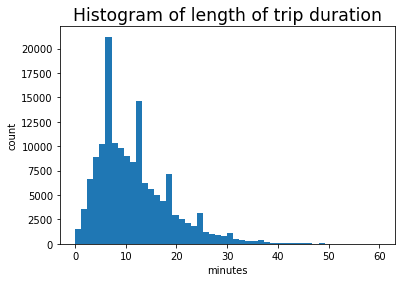

In [31]:
temp=(trips["destination_datetime"]-
                         trips["origin_datetime"])/datetime.timedelta(minutes=1)
plotter.figure()
plotter.hist(temp,range=(0,60),bins=50)
title="Histogram of length of trip duration"
plotter.title(title,fontsize="xx-large")
plotter.xlabel("minutes",fontsize="medium")
plotter.ylabel("count",fontsize="medium")
plotter.show()
plotter.close()

In [32]:
trips["origin_hour"]=trips["origin_datetime"].apply(lambda dt: dt.hour)
trips.set_index(["origin_hour","origin_node","destination_node"],
                drop=True,inplace=True)
trips.head()

,,,origin_datetime,destination_datetime
origin_hour,origin_node,destination_node,,
17,4163883691,42435675,2016-03-03 17:49:00,2016-03-03 18:11:00
8,42446998,42446701,2016-03-07 08:01:00,2016-03-07 08:12:00
17,42457476,42435518,2016-03-11 17:10:00,2016-03-11 17:23:00
19,42451375,42449613,2016-03-16 19:58:00,2016-03-16 20:03:00
23,42428444,42456060,2016-03-08 23:29:00,2016-03-08 23:48:00


In [33]:
temp=trips.groupby(level=["origin_node","destination_node"])
print(str(len(temp))+" unique trips")

138631 unique trips


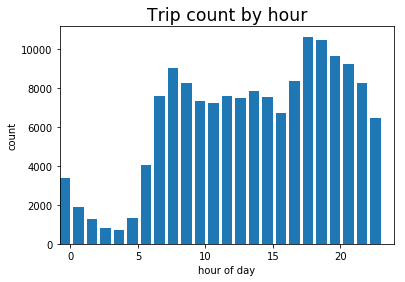

In [40]:
temp=trips.groupby(level="origin_hour").size()
temp.head()
plotter.figure()
width=0.8
plotter.bar(temp.index-width/2,
            numpy.array(temp),
           width=width)
title="Trip count by hour"
plotter.title(title,fontsize="xx-large")
plotter.xlim((-width,24))
plotter.xlabel("hour of day",fontsize="medium")
plotter.ylabel("count",fontsize="medium")
plotter.savefig("images/trip_count_by_hour.png",bbox_inches='tight')
plotter.show()
plotter.close()